In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/Users/amiyaguchi/wikipedia-retention


# Spark Preprocessing

In [3]:
from src.data.snap_import_user_projection import UnimodalUserProjection
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.getOrCreate()

input_path = "data/processed/enwiki-meta-compact"
model = UnimodalUserProjection(spark).extract(input_path).transform()

In [4]:
spark.table("bipartite").cache()
spark.table("bipartite").count()

53595946

In [5]:
contribution_df = spark.sql("""
select *, n_users*(n_users-1)/2 as clique_edges
from (
    select
        article_id,
        edit_date,
        approx_count_distinct(user_id) as n_users
    from bipartite
    group by 1, 2
    order by 3 desc
)
""")

In [6]:
contribution_df.cache()
# number of article-block
contribution_df.count()

44958309

In [7]:
(
    contribution_df
    .groupBy("n_users")
    .agg(F.expr("count(distinct article_id, edit_date) as n_cliques"))
    .orderBy(F.desc("n_users"))
).show()

+-------+---------+
|n_users|n_cliques|
+-------+---------+
|    612|        1|
|    599|        1|
|    461|        1|
|    375|        1|
|    300|        1|
|    272|        2|
|    255|        1|
|    239|        1|
|    237|        1|
|    231|        2|
|    225|        2|
|    222|        1|
|    199|        2|
|    190|        1|
|    182|        1|
|    180|        2|
|    165|        1|
|    164|        1|
|    161|        1|
|    157|        1|
+-------+---------+
only showing top 20 rows



In [8]:
contribution_df.selectExpr("sum(clique_edges)").show()

+-----------------+
|sum(clique_edges)|
+-----------------+
|      1.8649507E7|
+-----------------+



In [9]:
(
    contribution_df
    .selectExpr(
        "min(n_users)",
        "max(n_users)",
        "percentile(n_users, 0.25)",
        "percentile(n_users, 0.5)",
        "percentile(n_users, 0.9)",
        "percentile(n_users, 0.99)",
        "percentile(n_users, 0.999)",
        "percentile(n_users, 0.9999)",
        "percentile(n_users, 0.99999)",
        "percentile(n_users, 0.999999)",
    )
).show(truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------
 min(n_users)                                     | 1                  
 max(n_users)                                     | 612                
 percentile(n_users, CAST(0.25 AS DOUBLE), 1)     | 1.0                
 percentile(n_users, CAST(0.5 AS DOUBLE), 1)      | 1.0                
 percentile(n_users, CAST(0.9 AS DOUBLE), 1)      | 2.0                
 percentile(n_users, CAST(0.99 AS DOUBLE), 1)     | 4.0                
 percentile(n_users, CAST(0.999 AS DOUBLE), 1)    | 8.0                
 percentile(n_users, CAST(0.9999 AS DOUBLE), 1)   | 20.0               
 percentile(n_users, CAST(0.99999 AS DOUBLE), 1)  | 55.0               
 percentile(n_users, CAST(0.999999 AS DOUBLE), 1) | 130.08338399231434 



In [10]:
(
    contribution_df
    .selectExpr(
        "min(clique_edges)",
        "max(clique_edges)",
        "percentile(clique_edges, 0.25)",
        "percentile(clique_edges, 0.5)",
        "percentile(clique_edges, 0.75)",
        "percentile(clique_edges, 0.9)",
        "percentile(clique_edges, 0.99)",
        "percentile(clique_edges, 0.999)",
        "percentile(clique_edges, 0.9999)",
        "percentile(clique_edges, 0.99999)",
        "percentile(clique_edges, 0.999999)",
    )
).show(truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------
 min(clique_edges)                                     | 0.0               
 max(clique_edges)                                     | 186966.0          
 percentile(clique_edges, CAST(0.25 AS DOUBLE), 1)     | 0.0               
 percentile(clique_edges, CAST(0.5 AS DOUBLE), 1)      | 0.0               
 percentile(clique_edges, CAST(0.75 AS DOUBLE), 1)     | 0.0               
 percentile(clique_edges, CAST(0.9 AS DOUBLE), 1)      | 1.0               
 percentile(clique_edges, CAST(0.99 AS DOUBLE), 1)     | 6.0               
 percentile(clique_edges, CAST(0.999 AS DOUBLE), 1)    | 28.0              
 percentile(clique_edges, CAST(0.9999 AS DOUBLE), 1)   | 190.0             
 percentile(clique_edges, CAST(0.99999 AS DOUBLE), 1)  | 1485.0            
 percentile(clique_edges, CAST(0.999999 AS DOUBLE), 1) | 8395.881610997021 



In [11]:
# based on the degree distribution, how 

contribution_df.where("clique_edges <= 6").selectExpr("sum(clique_edges)").show()

+-----------------+
|sum(clique_edges)|
+-----------------+
|        8721692.0|
+-----------------+



In [50]:
(10e6 * 12) / 1e9  # GB of edge space

0.12

In [12]:
items = (
    contribution_df
    .groupBy("n_users")
    .agg(F.expr("count(distinct article_id, edit_date) as n_cliques"))
).collect()

In [13]:
import matplotlib.pyplot as plt
import numpy as np

n_users, n_cliques = zip(*[(r.n_users, r.n_cliques) for r in items])

plt.scatter(n_users, n_cliques)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("cliques of size k")
plt.ylabel("number of cliques")
plt.show()

<Figure size 640x480 with 1 Axes>

In [15]:
contribution_df.groupby().agg(F.expr('sum(n_users)')).show()

+------------+
|sum(n_users)|
+------------+
|    53568658|
+------------+



In [84]:
import pandas as pd
from scipy.stats import powerlaw
import pyspark.sql.types as T

schema = T.StructType([
    T.StructField("a", T.DoubleType(), False),
    T.StructField("loc", T.DoubleType(), False),
    T.StructField("scale", T.DoubleType(), False),
])
@F.pandas_udf(schema, F.PandasUDFType.GROUPED_MAP)
def powerlaw_fit(df):
    a, loc, scale = powerlaw.fit(df.n_users)
    return pd.DataFrame([(a, loc, scale)], columns=schema.names)

(
    contribution_df
    .select("n_users")
    .sample(0.1)
    .groupby()
    .apply(powerlaw_fit)
    .show()
)

+-------------------+------------------+------------------+
|                  a|               loc|             scale|
+-------------------+------------------+------------------+
|0.10844921426295023|0.9999999999999999|141.10567078127934|
+-------------------+------------------+------------------+



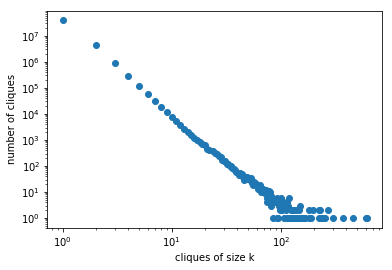

In [85]:
plt.scatter(n_users, n_cliques)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("cliques of size k")
plt.ylabel("number of cliques")
plt.show()

## Testing the structure of the blocking method

In [53]:
spark.table("bipartite").printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- article_id: integer (nullable = true)
 |-- edit_date: string (nullable = true)
 |-- word_count: double (nullable = true)
 |-- num_edits: long (nullable = false)



In [87]:
user_stats = spark.sql("""
select
    user_id,
    approx_count_distinct(article_id) as n_articles,
    approx_count_distinct(edit_date) as n_edits,
    sum(word_count) as contribution
from bipartite
group by 1
""")

In [88]:
data = user_stats.collect()

In [89]:
import numpy as np
import matplotlib.pyplot as plt

x, y, z = map(np.array, zip(*(
    (r.contribution, r.n_articles, r.n_edits) for r in data
    if r.contribution and r.n_articles and r.n_edits
)))

In [107]:
from scipy.stats import linregress

xx, yy, zz = map(np.log, [x+1, y+1, z+1])

0.7737974270957465


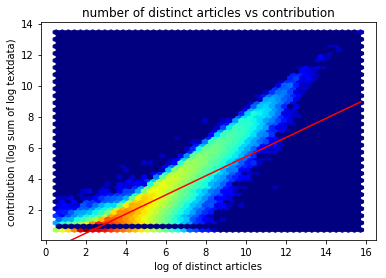

In [110]:
m, b, r, _, _ = linregress(xx, yy)
print(r**2)
plt.hexbin(xx, yy, gridsize=50, bins='log', cmap='jet')
ax = plt.gca()
ax.set_autoscale_on(False)
x_vals = np.linspace(1, max(xx))
plt.plot(x_vals, x_vals*m+b, 'r')
plt.title("number of distinct articles vs contribution")
plt.xlabel("log of distinct articles")
plt.ylabel("contribution (log sum of log textdata)")
plt.show()

0.7623663138446564


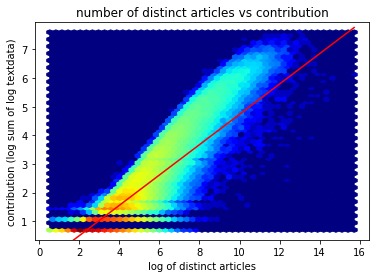

In [113]:
m, b, r, _, _ = linregress(xx, zz)
print(r**2)
plt.hexbin(xx, zz, gridsize=50, bins='log', cmap='jet')
ax = plt.gca()
ax.set_autoscale_on(False)
x_vals = np.linspace(1, max(xx))
plt.plot(x_vals, x_vals*m+b, 'r')
plt.title("number of distinct articles vs contribution")
plt.xlabel("log of distinct articles")
plt.ylabel("contribution (log sum of log textdata)")
plt.show()

### Statistics on the projection

In [166]:
admins_df = spark.read.csv("data/processed/admins.csv").toDF("username")
admins_df.createOrReplaceTempView("admins")
spark.sql("select count(*) from admins").show()

+--------+
|count(1)|
+--------+
|     997|
+--------+



In [118]:
spark.sql("select * from projection limit 10").show()

+------+-------+---------------+
|    e1|     e2|shared_articles|
+------+-------+---------------+
| 44750|2118749|              1|
| 84417| 921428|              2|
|282514| 750223|             10|
|195268| 431094|              2|
|195268| 283113|             38|
|473593|1033522|              1|
|253449| 705785|              3|
| 21492|1185156|              8|
|750223| 764050|              2|
|282780| 318837|              2|
+------+-------+---------------+



In [119]:
spark.table("projection").cache()
spark.table("projection").count()

12632948

In [120]:
spark.table("projection").printSchema()

root
 |-- e1: integer (nullable = true)
 |-- e2: integer (nullable = true)
 |-- shared_articles: long (nullable = false)



In [124]:
spark.sql(
"""
select count(distinct user_id)
from (
    select distinct e1 as user_id from projection
    union
    select distinct e2 as user_id from projection
)
"""
).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 943475|
+-----------------------+



In [131]:
user_degrees = spark.sql(
"""
select
    e1 as user_id,
    count(distinct e2) as degree
from (
    select e1, e2 from projection
    union
    select e2 as e1, e1 as e2 from projection
)
group by 1
"""
)

In [132]:
user_degrees.cache()
user_degrees.count()

943475

In [133]:
x, y = zip(*[(r.degree, r.n_users) for r in
(
    user_degrees
    .groupby("degree")
    .agg(F.expr("count(distinct user_id) as n_users"))
    .collect()
)])

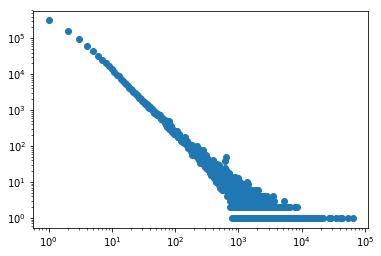

In [134]:
plt.scatter(x,y)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [173]:
mapping = spark.sql("""
with ids as (
    select distinct user_id, username
    from enwiki
)
select ids.user_id, ids.username
from ids
inner join admins on ids.username = admins.username
""")
mapping.cache()
mapping.count()

750

In [210]:
import shutil
import glob

name = "admin_mapping"
interim_path = "data/interim/{}".format(name)
mapping.repartition(1).write.csv(interim_path, mode="overwrite")
interim_file = glob.glob("{}/*.csv".format(interim_path))[0]
processed_file = "data/processed/{}.csv".format(name)
shutil.copy(interim_file, processed_file)
shutil.rmtree(interim_path)

In [186]:
(
    user_degrees
    .join(mapping, on="user_id", how="inner")
    .selectExpr(
        "avg(degree) as avg_deg",
        "stddev_pop(degree) as stddev_deg",
        "percentile(degree, 0.5) as median",
        "count(*) as n_samples"
    )
    .withColumn("error_bound", F.expr("stddev_deg*1.96/sqrt(n_samples)"))
).show(vertical=True)

-RECORD 0-------------------------
 avg_deg     | 2178.5989304812833 
 stddev_deg  | 2369.0861952745763 
 median      | 1516.5             
 n_samples   | 748                
 error_bound | 169.7798456884869  



In [188]:
(
    user_degrees
    .sample(0.1)
    .selectExpr(
        "avg(degree) as avg_deg",
        "stddev_pop(degree) as stddev_deg",
        "percentile(degree, 0.5) as median",
        "count(*) as n_samples"
    )
    .withColumn("error_bound", F.expr("stddev_deg*1.96/sqrt(n_samples)"))
).show(vertical=True)

-RECORD 0-------------------------
 avg_deg     | 26.917515640852216 
 stddev_deg  | 276.4884523367102  
 median      | 3.0                
 n_samples   | 94624              
 error_bound | 1.7617018785981844 



In [194]:
x_deg, y_contrib = zip(*[(r.degree, r.contribution) for r in 
      user_stats.join(user_degrees, on="user_id", how="inner").collect()])

0.44349652200866674


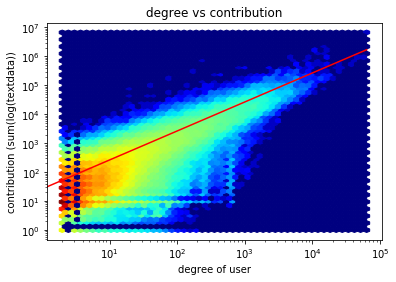

In [208]:
x_deg, y_contrib = map(np.array, [x_deg, y_contrib])
m, b, r, p, _ = linregress(x_deg, y_contrib)
print(r**2)
plt.hexbin(x_deg+1, y_contrib+1, gridsize=50, bins='log', cmap='jet', xscale='log', yscale='log')
plt.xlabel("degree of user")
plt.ylabel("contribution (sum(log(textdata))")
plt.title("degree vs contribution")
ax = plt.gca()
ax.set_autoscale_on(False)
x_vals = np.linspace(0, max(x_deg))
plt.plot(x_vals, x_vals*m+b, 'r')
plt.show()

In [209]:
! ls data/processed

2007-1-enwiki-projection-user-dev.csv   all_article_features.csv
2007-1-enwiki-projection-user-roles.csv all_user_features.csv
2007-1-enwiki-projection-user.csv       base_features_reg.csv
2007Q1-user-network-v1.csv              community_norm_features.csv
2007Q1-user-network-v2.csv              enwiki-meta-compact
2007Q1-user-roles-v2.txt                enwiki-projection-user-dev.csv
admins.csv                              kcore-2007-1.csv
